In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# then, for convenience
%cd /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main


In [ ]:
!nvidia-smi

Tue Dec  2 16:09:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   35C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%pip -q install --upgrade pip
# Use Colab's Torch by default. Install the rest:
%pip -q install numpy pandas scikit-learn scipy tqdm "dython==0.6.4.post1"

# (Only if PyTorch import fails; otherwise skip)
try:
    import torch, sys; print("Torch OK:", torch.__version__)
except Exception as e:
    print("Installing PyTorch for GPU...")
    %pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 85.2 MB/s eta 0:00:00
Torch OK: 2.9.0+cu126


In [ ]:
import os, glob, sys

# look for any folder under /content/work or Drive that has a "model" subfolder
candidates = []
for base in ["/content/work", "/content", "/content/drive/MyDrive"]:
    candidates += [p for p in glob.glob(base + "/**/*", recursive=True)
                   if os.path.isdir(os.path.join(p, "model"))]

if not candidates:
    raise FileNotFoundError("Couldn't find a folder that contains a 'model' directory. "
                            "Check the ZIP path or clone the repo, then re-run this cell.")

REPO = sorted(candidates, key=len)[0]  # shortest path first
print("Using repo root:", REPO)
os.chdir(REPO)

# sanity check
assert os.path.exists("model/ctabgan.py"), "Expected file 'model/ctabgan.py' not found here."
print("PWD:", os.getcwd())
!ls -la


Using repo root: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main
PWD: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main
total 47
-rw------- 1 root root 10244 Nov 18 16:51 .DS_Store
-rw------- 1 root root  4260 Nov 18 16:51 Experiment_Script_Adult.ipynb
-rw------- 1 root root 13061 Nov 18 16:51 Experiment_Script_king.ipynb
drwx------ 2 root root  4096 Nov 18 16:55 Fake_Datasets
drwx------ 2 root root  4096 Nov 18 16:55 .ipynb_checkpoints
drwx------ 7 root root  4096 Nov 18 16:55 model
-rw------- 1 root root  2756 Nov 18 16:51 README.md
drwx------ 2 root root  4096 Nov 18 16:55 Real_Datasets


In [ ]:
import os, sys, pathlib

# add this repo root to sys.path (first position)
repo_root = os.getcwd()
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

# make packages explicit (helps some Colab/Python versions)
for pkg in ["model", "model/eval", "model/synthesizer"]:
    path = pathlib.Path(pkg)
    path.mkdir(parents=True, exist_ok=True)
    initf = path / "__init__.py"
    if not initf.exists():
        initf.write_text("")  # empty file
print("sys.path[0]:", sys.path[0])


sys.path[0]: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main


In [ ]:
from model.ctabgan import CTABGAN
print("✅ Imported CTABGAN successfully")


✅ Imported CTABGAN successfully


In [ ]:
from model.ctabgan import CTABGAN
import os

ctab = CTABGAN()          # uses defaults for Adult.csv and column config
ctab.fit()                # train
fake = ctab.generate_samples()  # sample same number of rows as real
os.makedirs('Fake_Datasets', exist_ok=True)
fake_path = 'Fake_Datasets/Adult_fake.csv'
fake.to_csv(fake_path, index=False)
print("Saved:", fake_path)


100%|██████████| 150/150 [38:09<00:00, 15.26s/it]


Finished training in 2318.686017513275  seconds.
Saved: Fake_Datasets/Adult_fake.csv


In [ ]:
!mkdir -p "/content/drive/MyDrive/CTAB-GAN-Plus-outputs"
!cp "Fake_Datasets/Adult_fake.csv" "/content/drive/MyDrive/CTAB-GAN-Plus-outputs/"
print("Wrote to /content/drive/MyDrive/CTAB-GAN-Plus-outputs/Adult_fake.csv")


Wrote to /content/drive/MyDrive/CTAB-GAN-Plus-outputs/Adult_fake.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from model.eval.evaluation import stat_sim, privacy_metrics
real_path = "Real_Datasets/Adult.csv"
cat_cols = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country','income']  # matches repo's Adult.csv
print("Stat similarity:", stat_sim(real_path, 'Fake_Datasets/Adult_fake.csv', cat_cols))
print("Privacy metrics:", privacy_metrics(real_path, 'Fake_Datasets/Adult_fake.csv'))


column:  age WD:  0.036577266477930234
column:  workclass JSD:  0.04745791553069061
column:  fnlwgt WD:  0.004994650626736045
column:  education JSD:  0.10045498195270541
column:  marital-status JSD:  0.04184221673451808
column:  occupation JSD:  0.047254600977764585
column:  relationship JSD:  0.019361426007275896
column:  race JSD:  0.017701528163937955
column:  gender JSD:  0.03833991252065376
column:  capital-gain WD:  0.0037508308828635107
column:  capital-loss WD:  0.020985077761845897
column:  hours-per-week WD:  0.008752712829122478
column:  native-country JSD:  0.09081596969717176
column:  income JSD:  0.002204432374421408
Stat similarity: [np.float64(0.015012107715699632), np.float64(0.04504810932879328), np.float64(0.3146078283274025)]
Privacy metrics: [[0.32408266 0.21654549 0.28891389 0.52757823 0.44205225 0.50004152]]


In [ ]:
import pandas as pd
df = pd.read_csv("Real_Datasets/diabetes_binary.csv")

# Basic heuristics (tweak as needed)
categorical_columns = df.select_dtypes(include=['object','category','bool']).columns.tolist()
integer_columns = [c for c in df.columns if pd.api.types.is_integer_dtype(df[c])]
log_columns = []  # numeric columns that are strictly positive and benefit from log transform
mixed_columns = {}  # e.g., {'amount':[0.0]} if a numeric column is mostly zeros but positive when >0
general_columns = []  # continuous columns not in log/mixed
non_categorical_columns = [c for c in df.columns if c not in categorical_columns]

# Example: classification on column "label"
problem_type = {"Classification": "label"}

from model.ctabgan import CTABGAN
g = CTABGAN(
    raw_csv_path="Real_Datasets/diabetes_binary.csv",
    test_ratio=0.2,
    categorical_columns=categorical_columns,
    log_columns=log_columns,
    mixed_columns=mixed_columns,
    general_columns=general_columns,
    non_categorical_columns=non_categorical_columns,
    integer_columns=integer_columns,
    problem_type=problem_type
)
g.fit()
syn = g.generate_samples()
syn.to_csv("Fake_Datasets/diabetes_binary_fake.csv", index=False)
print("Saved: Fake_Datasets/diabetes_binary_fake.csv")


KeyError: 'label'

In [ ]:
# === Cell 1: imports & helper ===
import io, re, sys, os, contextlib
import pandas as pd
import matplotlib.pyplot as plt

from model.ctabgan import CTABGAN  # must succeed

def fit_with_history_plot(ctabgan: CTABGAN, **fit_kwargs):
    """
    Trains CTAB-GAN+ and plots generator/discriminator losses.
    1) First tries to read built-in loss history if available.
    2) Otherwise parses stdout logs for G/D losses.
    Returns: (history_df, raw_log_str)
    """
    # ---- run training while capturing stdout ----
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        ctabgan.fit(**fit_kwargs)
    log = buf.getvalue()

    # ---- try to read histories directly from the synthesizer, if exposed ----
    history_df = None
    try:
        synth = getattr(ctabgan, "synthesizer", None)
        g_hist = None
        d_hist = None
        if synth is not None:
            # common attribute name guesses:
            for cand_g in ["g_losses", "loss_g_history", "G_losses", "gen_losses"]:
                if hasattr(synth, cand_g):
                    g_hist = list(getattr(synth, cand_g))
                    break
            for cand_d in ["d_losses", "loss_d_history", "D_losses", "disc_losses"]:
                if hasattr(synth, cand_d):
                    d_hist = list(getattr(synth, cand_d))
                    break
        if g_hist and d_hist and len(g_hist) == len(d_hist):
            history_df = pd.DataFrame({
                "epoch": range(1, len(g_hist) + 1),
                "g_loss": [float(x) for x in g_hist],
                "d_loss": [float(x) for x in d_hist],
            })
    except Exception:
        history_df = None  # fall through to log parse

    # ---- fallback: parse losses from printed logs ----
    if history_df is None:
        g_list, d_list = [], []
        for line in log.splitlines():
            # match formats like: "G: 3.21", "Generator: 3.21", "loss_g: 3.21"
            m_g = (
                re.search(r'\b(?:G|Gen(?:erator)?)\s*[:=]\s*(-?\d+(?:\.\d+)?(?:e[+-]?\d+)?)', line, re.I) or
                re.search(r'\bloss[_\s]*g\s*[:=]\s*(-?\d+(?:\.\d+)?(?:e[+-]?\d+)?)', line, re.I)
            )
            m_d = (
                re.search(r'\b(?:D|Disc(?:riminator)?)\s*[:=]\s*(-?\d+(?:\.\d+)?(?:e[+-]?\d+)?)', line, re.I) or
                re.search(r'\bloss[_\s]*d\s*[:=]\s*(-?\d+(?:\.\d+)?(?:e[+-]?\d+)?)', line, re.I)
            )
            if m_g:
                g_list.append(float(m_g.group(1)))
            if m_d:
                d_list.append(float(m_d.group(1)))

        # align lengths conservatively
        k = min(len(g_list), len(d_list))
        if k == 0:
            raise RuntimeError(
                "Could not find loss values in logs. "
                "Try lowering verbosity filters or exposing g/d histories in the repo."
            )
        history_df = pd.DataFrame({
            "epoch": range(1, k + 1),
            "g_loss": g_list[:k],
            "d_loss": d_list[:k],
        })

    # ---- plot (single chart, no special colors/styles) ----
    plt.figure()
    plt.plot(history_df["epoch"], history_df["g_loss"], label="Generator loss")
    plt.plot(history_df["epoch"], history_df["d_loss"], label="Discriminator loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CTAB-GAN+ Training Loss")
    plt.legend()
    plt.show()

    return history_df, log


In [ ]:
# === Cell 2: quick run on the built-in Adult dataset ===
# If you were already instantiating CTABGAN() in your notebook, reuse that object.
ctab = CTABGAN()  # uses repo defaults (e.g., Real_Datasets/Adult.csv and its column config)

history_df, training_log = fit_with_history_plot(ctab)

# (Optional) inspect / save the history data
display(history_df.head())
history_df.to_csv("training_history.csv", index=False)
print("Saved training history to training_history.csv")


100%|██████████| 150/150 [38:26<00:00, 15.38s/it]


RuntimeError: Could not find loss values in logs. Try lowering verbosity filters or exposing g/d histories in the repo.

In [ ]:
from model.ctabgan import CTABGAN

ctab = CTABGAN()
ctab.fit()

print("len(g_losses), len(d_losses) =>", len(ctab.synthesizer.g_losses), len(ctab.synthesizer.d_losses))
print("Last G/D:", ctab.synthesizer.g_losses[-1] if ctab.synthesizer.g_losses else None,
                  ctab.synthesizer.d_losses[-1] if ctab.synthesizer.d_losses else None)


100%|██████████| 150/150 [37:52<00:00, 15.15s/it]

Finished training in 2294.001583814621  seconds.
len(g_losses), len(d_losses) => 0 0
Last G/D: None None


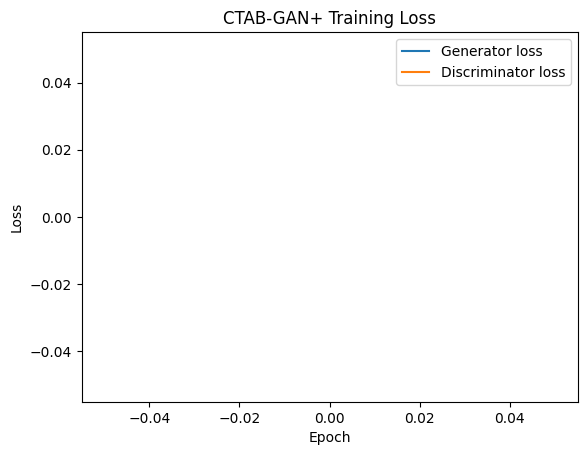

In [ ]:
import matplotlib.pyplot as plt
g = ctab.synthesizer.g_losses
d = ctab.synthesizer.d_losses
epochs = range(1, min(len(g), len(d)) + 1)
plt.figure()
plt.plot(epochs, g[:len(epochs)], label="Generator loss")
plt.plot(epochs, d[:len(epochs)], label="Discriminator loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("CTAB-GAN+ Training Loss"); plt.legend()
plt.show()


In [ ]:
# === RECOVERY CELL: find repo root, fix sys.path, and retry imports ===
import os, sys, glob, pathlib, importlib

# 1) Find a folder that contains "model/ctabgan.py"
candidates = []
for base in ["/content/work", "/content", "/content/drive/MyDrive"]:
    candidates += [p for p in glob.glob(base + "/**/*", recursive=True)
                   if os.path.isfile(os.path.join(p, "model", "ctabgan.py"))]

if not candidates:
    raise FileNotFoundError(
        "Couldn't find a folder that contains model/ctabgan.py.\n"
        "- If you have a ZIP, unzip it first (to /content/work or Drive).\n"
        "- Or %cd into your CTAB-GAN+ folder manually, then rerun this cell."
    )

# Prefer the shortest path (likely the actual repo root, avoids nested folders)
REPO = sorted(candidates, key=len)[0]
os.chdir(REPO)
print("Using repo root:", os.getcwd())

# 2) Ensure Python can import from this folder
if REPO not in sys.path:
    sys.path.insert(0, REPO)

# 3) Make sure 'model', 'model/eval', 'model/synthesizer' are packages
for pkg in ["model", "model/eval", "model/synthesizer"]:
    pkg_path = pathlib.Path(pkg)
    pkg_path.mkdir(parents=True, exist_ok=True)
    initf = pkg_path / "__init__.py"
    if not initf.exists():
        initf.write_text("")  # mark as a package

# 4) Clear any old cached imports & retry
for m in list(sys.modules):
    if m.startswith("model"):
        del sys.modules[m]

# 5) Try the imports (both high-level and the synthesizer file)
from model.ctabgan import CTABGAN
print("✅ from model.ctabgan import CTABGAN — OK")

import importlib.util
spec = importlib.util.find_spec("model.synthesizer.ctabgan_synthesizer")
print("ctabgan_synthesizer visible?", spec is not None)
if spec is None:
    raise ModuleNotFoundError("model.synthesizer.ctabgan_synthesizer not found even after setup.")

import model.synthesizer.ctabgan_synthesizer as synth_mod
print("✅ model.synthesizer.ctabgan_synthesizer imported from:", synth_mod.__file__)


Using repo root: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main
✅ from model.ctabgan import CTABGAN — OK
ctabgan_synthesizer visible? True
✅ model.synthesizer.ctabgan_synthesizer imported from: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main/model/synthesizer/ctabgan_synthesizer.py


In [ ]:
# === RECOVERY CELL: find repo root, fix sys.path, and retry imports ===
import os, sys, glob, pathlib, importlib

# 1) Find a folder that contains "model/ctabgan.py"
candidates = []
for base in ["/content/work", "/content", "/content/drive/MyDrive"]:
    candidates += [p for p in glob.glob(base + "/**/*", recursive=True)
                   if os.path.isfile(os.path.join(p, "model", "ctabgan.py"))]

if not candidates:
    raise FileNotFoundError(
        "Couldn't find a folder that contains model/ctabgan.py.\n"
        "- If you have a ZIP, unzip it first (to /content/work or Drive).\n"
        "- Or %cd into your CTAB-GAN+ folder manually, then rerun this cell."
    )

# Prefer the shortest path (likely the actual repo root, avoids nested folders)
REPO = sorted(candidates, key=len)[0]
os.chdir(REPO)
print("Using repo root:", os.getcwd())

# 2) Ensure Python can import from this folder
if REPO not in sys.path:
    sys.path.insert(0, REPO)

# 3) Make sure 'model', 'model/eval', 'model/synthesizer' are packages
for pkg in ["model", "model/eval", "model/synthesizer"]:
    pkg_path = pathlib.Path(pkg)
    pkg_path.mkdir(parents=True, exist_ok=True)
    initf = pkg_path / "__init__.py"
    if not initf.exists():
        initf.write_text("")  # mark as a package

# 4) Clear any old cached imports & retry
for m in list(sys.modules):
    if m.startswith("model"):
        del sys.modules[m]

# 5) Try the imports (both high-level and the synthesizer file)
from model.ctabgan import CTABGAN
print("✅ from model.ctabgan import CTABGAN — OK")

import importlib.util
spec = importlib.util.find_spec("model.synthesizer.ctabgan_synthesizer")
print("ctabgan_synthesizer visible?", spec is not None)
if spec is None:
    raise ModuleNotFoundError("model.synthesizer.ctabgan_synthesizer not found even after setup.")

import model.synthesizer.ctabgan_synthesizer as synth_mod
print("✅ model.synthesizer.ctabgan_synthesizer imported from:", synth_mod.__file__)


Using repo root: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main
✅ from model.ctabgan import CTABGAN — OK
ctabgan_synthesizer visible? True
✅ model.synthesizer.ctabgan_synthesizer imported from: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main/model/synthesizer/ctabgan_synthesizer.py


In [ ]:
# ===== TRIAGE CELL: run me after `from model.ctabgan import CTABGAN` succeeds =====
import os, sys, glob, traceback, textwrap, inspect
import numpy as np

def check_file(p):
    print(f"[exists] {p} ->", os.path.exists(p))

def list_here(path="."):
    try:
        print("---- ls -la", os.path.abspath(path))
        for name in sorted(os.listdir(path))[:200]:
            print(" ", name)
        print("---- end ls")
    except Exception as e:
        print("ls failed:", e)

def env_report():
    print("### ENV / VERSIONS")
    try:
        import torch;  print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())
    except Exception as e:
        print("torch import error:", e)
    try:
        import numpy as np; print("numpy:", np.__version__)
    except Exception as e:
        print("numpy import error:", e)
    try:
        import pandas as pd; print("pandas:", pd.__version__)
    except Exception as e:
        print("pandas import error:", e)
    try:
        import sklearn; print("scikit-learn:", sklearn.__version__)
    except Exception as e:
        print("sklearn import error:", e)

def synth_report(ctab):
    syn = getattr(ctab, "synthesizer", None)
    print("\n### SYNTHESIZER")
    print("has synthesizer:", syn is not None)
    if syn is not None:
        for attr in ["epochs","num_epochs","batch_size","lr"]:
            if hasattr(syn, attr): print(attr, "=", getattr(syn, attr))
        # try common loss attributes
        for name in ["g_losses","loss_g_history","G_losses","gen_losses",
                     "d_losses","loss_d_history","D_losses","disc_losses"]:
            if hasattr(syn, name):
                v = getattr(syn, name)
                try:
                    print(f"{name}: len={len(list(v))}")
                except Exception:
                    print(f"{name}: exists (len unknown)")

print("CWD:", os.getcwd())
list_here()
check_file("model/ctabgan.py")
check_file("Real_Datasets/Adult.csv")
env_report()

# Try a short training run and plot robustly
import matplotlib.pyplot as plt
from model.ctabgan import CTABGAN

try:
    # If your class accepts hyperparams, you can pass small values while debugging:
    # ctab = CTABGAN(epochs=5, batch_size=256, lr=2e-4)
    ctab = CTABGAN()
    print("\n### TRAINING (capturing any exceptions) ...")
    ctab.fit()
    print("fit() completed.")
    synth_report(ctab)

    # gather losses from common attributes
    syn = ctab.synthesizer
    def pick(name_list):
        for n in name_list:
            if hasattr(syn, n):
                try:
                    return [float(x) for x in list(getattr(syn, n))]
                except Exception:
                    pass
        return []
    g = pick(["g_losses","loss_g_history","G_losses","gen_losses"])
    d = pick(["d_losses","loss_d_history","D_losses","disc_losses"])

    # If lists are empty, explain and bail early
    if not g or not d:
        print("\nNo usable G/D loss arrays found (length 0). Common causes:")
        print("- Patch to record losses wasn’t executed (module not reloaded).")
        print("- Wrong variable names in your patch (e.g., code uses errG/errD).")
        print("- Training loop didn’t run (epochs=0 or dataset path missing).")
    else:
        # Clean and align
        g = np.array(g, dtype=float); d = np.array(d, dtype=float)
        mask = np.isfinite(g) & np.isfinite(d)
        g, d = g[mask], d[mask]
        k = min(len(g), len(d))
        if k == 0:
            print("All losses were NaN/inf or lengths mismatched.")
        else:
            print(f"Plotting {k} epochs. First/last G: {g[0]:.6f}/{g[-1]:.6f} D: {d[0]:.6f}/{d[-1]:.6f}")
            plt.figure()
            plt.plot(range(1, k+1), g[:k], label="Generator loss")
            plt.plot(range(1, k+1), d[:k], label="Discriminator loss")
            plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("CTAB-GAN+ Training Loss"); plt.legend()
            plt.show()

except Exception as e:
    print("\n### EXCEPTION DURING TRAIN/REPORT ###")
    traceback.print_exc()
    print("\nQuick fixes to try:")
    print("- Restart runtime, then re-run the import + training cells (ensures patched code is loaded).")
    print("- Verify dataset exists at Real_Datasets/Adult.csv or pass your CSV path to CTABGAN().")
    print("- If you added loss tracking, confirm it’s inside the epoch loop and uses the exact loss tensor names.")


CWD: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main
---- ls -la /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main
  .DS_Store
  .ipynb_checkpoints
  Experiment_Script_Adult.ipynb
  Experiment_Script_king.ipynb
  Fake_Datasets
  README.md
  Real_Datasets
  model
---- end ls
[exists] model/ctabgan.py -> True
[exists] Real_Datasets/Adult.csv -> True
### ENV / VERSIONS
torch: 2.9.0+cu126 | cuda: True
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1

### TRAINING (capturing any exceptions) ...


100%|██████████| 150/150 [38:11<00:00, 15.28s/it]

Finished training in 2323.343594789505  seconds.
fit() completed.

### SYNTHESIZER
has synthesizer: True
epochs = 150
batch_size = 500
g_losses: len=0
d_losses: len=0

No usable G/D loss arrays found (length 0). Common causes:
- Patch to record losses wasn’t executed (module not reloaded).
- Wrong variable names in your patch (e.g., code uses errG/errD).
- Training loop didn’t run (epochs=0 or dataset path missing).


In [ ]:
# DIAGNOSTIC CELL — run after you called ctab.fit()
import inspect, os, math, numpy as np
import matplotlib.pyplot as plt

def _arr_ok(a):
    return isinstance(a, (list, tuple)) and len(a) > 0

# 1) Check we’re using the edited module
import model.synthesizer.ctabgan_synthesizer as synth_mod
print("Synthesizer file:", synth_mod.__file__)
print("Contains g_losses attribute? ",
      "g_losses" in (inspect.getsource(synth_mod) if os.path.exists(synth_mod.__file__) else ""))

# 2) Pull losses (handles various attribute names)
syn = getattr(ctab, "synthesizer", None)
assert syn is not None, "ctab.synthesizer is None — did fit() run?"
cands_g = ["g_losses","loss_g_history","G_losses","gen_losses","g_loss"]
cands_d = ["d_losses","loss_d_history","D_losses","disc_losses","d_loss"]

def pick_attr(obj, names):
    for n in names:
        if hasattr(obj, n):
            v = getattr(obj, n)
            try:
                return [float(x) for x in list(v)]
            except Exception:
                pass
    return []

g = pick_attr(syn, cands_g)
d = pick_attr(syn, cands_d)
print(f"len(g)={len(g)}, len(d)={len(d)}")

# 3) If empty, explain the likely reason(s)
if not _arr_ok(g) or not _arr_ok(d):
    print("\nNo usable loss values found. Likely reasons:")
    print("- Patch didn’t run (restart runtime after editing, re-import CTABGAN).")
    print("- Patch uses wrong loss variable names; replace with the exact tensors used in your loop (e.g., errG/errD).")
    print("- Training loop didn’t execute (epochs=0, dataset missing/empty, early return).")
    # Extra: peek for epochs
    epochs_attr = getattr(syn, "epochs", getattr(syn, "num_epochs", None))
    print("epochs (if available):", epochs_attr)
else:
    # 4) Clean data (drop NaN/inf) and align
    def clean(a):
        a = np.array(a, dtype=float)
        mask = np.isfinite(a)
        return a[mask].tolist()
    g = clean(g); d = clean(d)
    k = min(len(g), len(d))
    if k == 0:
        print("All losses were NaN/inf or mismatched.")
    else:
        g = g[:k]; d = d[:k]
        # 5) Plot robustly
        plt.figure()
        plt.plot(range(1, k+1), g, label="Generator loss")
        plt.plot(range(1, k+1), d, label="Discriminator loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("CTAB-GAN+ Training Loss"); plt.legend()
        plt.show()
        print("Plotted", k, "epochs. First/last G:", g[0], g[-1], "D:", d[0], d[-1])


Synthesizer file: /content/drive/MyDrive/CTAB-GAN-Plus-main/CTAB-GAN-Plus-main/model/synthesizer/ctabgan_synthesizer.py
Contains g_losses attribute?  True


NameError: name 'ctab' is not defined

In [1]:
# ✅ Use versions that work with Python 3.10+ in current Colab
%pip -q install --upgrade pip

# If you already installed older pins in this session, wipe them first:
%pip -q uninstall -y numpy pandas scikit-learn scipy dython opacus

# Install a compatible set (works well with torch 2.x on Colab)
%pip -q install \
  numpy==1.23.5 \
  pandas==1.5.3 \
  scikit-learn==1.2.2 \
  scipy==1.10.1 \
  dython==0.7.4 \
  opacus==1.4.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> No available output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
ERROR: Failed to build 'numpy' when getting requirements to build wheel
